[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/programmable_self_assembly.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
  
def linf_distance((a,b),(x,y)):
  return max(abs(a-x),abs(b-y))
def l1_distance((a,b),(x,y)):
  return abs(a-x)+abs(b-y)
def displacement(initial,terminal):
  return (terminal[0]-initial[0], terminal[1]-initial[1])
def get_coordinates(array):
  return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
def arrow(direction):
  # arrows: http://xahlee.info/comp/unicode_arrows.html
  arrowdict = {'(-1, 0)':'🡑',
              '(-1, 1)':'🡕',
              '(0, 1)':'🡒',
              '(1, 1)':'🡖',
              '(1, 0)':'🡓',
              '(1, -1)':'🡗',
              '(0, -1)':'🡐',
              '(-1, -1)':'🡔'}
  return arrowdict[str(direction)]
def is_connected(pointlist,center):
  displist = [displacement(center,p) for p in pointlist]
  full_clockwise = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
  clockwise = [p for p in full_clockwise if p in displist]
  n = len(clockwise)
  distance_to_next = [linf_distance(clockwise[i],clockwise[(i+1)%n]) for i in range(n)]
  num_breaks = sum([bool(d>1) for d in distance_to_next])
  if num_breaks>1:
    return False
  else:
    return True
  
class Agents:
  
  ##########################
  ### PLOTTING / LOGGING ###
  ##########################
  
  def make_grid(self,highlight_agents_by_index=[],gradient=False):
    grid = np.ones((self.grid_shape[0],self.grid_shape[1],3))
    for p in self.template_coordinates:
      grid[p][0] = 1
      grid[p][1] = 1
      grid[p][2] = 125
      
    if gradient:
      max_gradient = max(self.gradient)
      for i,p in enumerate(self.agent_coordinates):
        val = 100+ 100*float(self.gradient[i])/max_gradient
        grid[p][0] = val
        grid[p][1] = val
        grid[p][2] = val
        if self.activity[i] == False:
          grid[p][2] = 1
        if i in highlight_agents_by_index:
          grid[p][1] = 1
    else:
      for i,p in enumerate(self.agent_coordinates):
        grid[p][0] = 200
        grid[p][1] = 200
        grid[p][2] = 200
        if self.activity[i] == False:
          grid[p][2] = 1
        if i in highlight_agents_by_index:
          grid[p][1] = 1
        
    return grid
  
  def update_logarray(self,highlight_agents_by_index=[]):
    grid = self.make_grid(highlight_agents_by_index=highlight_agents_by_index)
    self.logarray.append(grid)
    
  def plot(self,t=0,logarrayskip=1,showgradient=False):
    print self.logstr[t]
    if t != -1:
      grids = [self.logarray[logarrayskip+2*t],self.logarray[logarrayskip+2*t+1]]
    elif t == -1:
      grids = [self.logarray[logarrayskip+2*t]]
    for grid in grids:
      plt.imshow(grid)
      plt.grid(False)
      plt.show()
    if showgradient:
      gradarray1 = np.zeros(self.grid_shape)
      for ((x,y),g) in zip(a.coordinates_log[t],a.gradient_log[2*t+1]):
        gradarray1[x,y] = float(5+g)/10
      plt.imshow(gradarray1)
      plt.grid(False)
      plt.show() 
      gradarray2 = np.zeros(self.grid_shape)
      for ((x,y),g) in zip(a.coordinates_log[t],a.gradient_log[2*t+2]):
        gradarray1[x,y] = float(5+g)/10
      plt.imshow(gradarray2)
      plt.grid(False)
      plt.show() 
      #diffarray = np.zeros(self.grid_shape)
      #for x in range(self.grid_shape[0]):
      #  for y in range(self.grid_shape[1]):
      #    if grids[1][x,y][0] != grids[0][x,y][0] or grids[1][x,y][1] != grids[0][x,y][1] or grids[1][x,y][2] != grids[0][x,y][2]:
      #      diffarray[x,y] = 1
      #plt.imshow(diffarray)
      #plt.grid(False)
      #plt.show()
  
  #########################
  ### UPDATES UTILITIES ###
  #########################
  
  def prospective_location(self,i):
    (x0,y0) = self.agent_coordinates[i]
    (dx,dy) = self.direction[i]
    (x,y) = (x0+dx,y0+dy)
    return (x,y)
  
  def linf_distance_to_template(self,p):
    return min([linf_distance(p,t) for t in self.template_coordinates])
  
  def angle(self,i,p):
    p_direction = displacement(self.agent_coordinates[i],p)
    return l1_distance(self.direction[i],p_direction)
  
  def choose(self,i,plist):
    if len(plist) == 1:
      return plist[0]
    elif len(plist) >= 2:
      angles = [self.angle(i,p) for p in plist]
      leastangle = min(angles)
      plist = [plist[j] for j,a in enumerate(angles) if a==leastangle]
      if len(plist) == 1:
        return plist[0]
      else:
        distances = [self.linf_distance_to_template(p) for p in plist]
        leastdist = min(distances)
        plist = [plist[j] for j,d in enumerate(distances) if d==leastdist]
        if len(plist) == 1:
          return plist[0]
        elif len(plist) >= 2:
          return random.choice(plist)
  
  def surroundings(self,i):
    (x0,y0) = self.agent_coordinates[i]
    coordinates = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y0),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
    ans = [{'coordinates': (x,y),
            'is_unoccupied': (x,y) not in self.agent_coordinates,
            'is_in_template': (x,y) in self.template_coordinates,
            'is_in_grid': x in range(self.grid_shape[0]) and y in range(self.grid_shape[1])} for (x,y) in coordinates]
    return ans
  
  def edgefollows(self,i):
    surr = self.surroundings(i)
    p0 = self.agent_coordinates[i]
    occupied = [s['coordinates'] for s in surr if not s['is_unoccupied']]
    unoccupied = [s['coordinates'] for s in surr if s['is_unoccupied']]
    
    ans = []
    for p in unoccupied: # choose anything that keeps it connected
      if is_connected(list(occupied)+[p],p0):
        ans.append(p)
        
    surr_in_grid = [s['coordinates'] for s in surr if s['is_in_grid']]
    ans = [p for p in ans if p in surr_in_grid]
    
    return ans
     
    '''
    for k in range(8):
      o0, o1, o2, o3, o4, o5, o6, o7 = o[(k+0)%8], o[(k+1)%8], o[(k+2)%8], o[(k+3)%8], o[(k+4)%8], o[(k+5)%8], o[(k+6)%8], o[(k+7)%8]
      x0, x1, x2, x3, x4, x5, x6, x7 = not o0, not o1, not o2, not o3, not o4, not o5, not o6, not o7
      if o0 and o1 and o2 and o3:
        if x4 and x5 and x6 and x7:
          #  x  x  x
          #  x     o*
          #  o* o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+3)%8]['coordinates']]
          break
        elif x4 and x5 and o6 and x7:
          #  x  o* x
          #  x     o*
          #  o* o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+3)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
        elif x4 and x5 and o6 and x7:
          #  x  o* x
          #  x     o*
          #  o* o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+3)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
        elif o4 and x5 and x6 and x7:
          #  x  x  o*   x  x  x
          #  x     o    o*    o*
          #  o* o  o    o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
          break
        elif o4 and o5 and x6 and x7:
          #  x  x  o*
          #  o*    o
          #  o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+5)%8]['coordinates']]
          break
        elif o4 and x5 and o6 and x7:
          #  o* x  o*
          #  x     o
          #  o* o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
        elif o4 and o5 and o6 and x7:
          #  x  o* o
          #  o*    o
          #  o  o  o
          ans = [surr[(k+0)%8]['coordinates'],surr[(k+6)%8]['coordinates']]
          break
      elif o0 and o1 and o2 and o3 and x4 and o5 and o6 and x7:
        #  o  o* x
        #  x     o
        #  o  o  o
        ans = [surr[(k+6)%8]['coordinates']]
        break
      elif o0 and o1 and o2 and x3 and x4 and o5 and x6:
        #  o  e  x
        #  o     o*
        #  o  x  x
        ans = [surr[(k+5)%8]['coordinates']]
        break
      elif o0 and o1 and o2 and x3 and x4 and o5 and x6:
        #  o  x  x
        #  o     o*
        #  o  x  x
        ans = [surr[(k+5)%8]['coordinates']]
        break
      elif o0 and x1 and x2 and x3 and o4 and x5 and x6 and x7:
        #  x  x  x
        #  o*    o*
        #  x  x  x
        ans = [surr[(k+0)%8]['coordinates'],surr[(k+4)%8]['coordinates']]
        break
      elif o0 and x1 and x2 and x3 and x4 and x5 and x6 and x7:
        #  x  x  x
        #  x     o*
        #  x  x  x
        ans = [surr[(k+0)%8]['coordinates']]
        break

    surr_in_grid = [s['coordinates'] for s in surr if s['is_in_grid']]
    ans = [p for p in ans if p in surr_in_grid]
    
    return ans
    '''

  
  ###############
  ### UPDATES ###
  ###############
  
  def update_activity_according_to_gradient(self,i):
    if self.activity[i]: # activity update according to gradient
      p0 = self.agent_coordinates[i] 
      if p0 in self.template_coordinates: # if inside the shape
        inactive_neighbors = [j for j in self.neighbors[i] if self.activity[j]==False]
        #nondiagonal_inactive_neighbors = [j for j in inactive_neighbors if l1_distance(p0,self.agent_coordinates[j])==1]
        if len(inactive_neighbors)>0:
          if any([self.gradient[i] == self.gradient[j] for j in inactive_neighbors]): # turn off if  inactive neighbor has same gradient value
            self.activity[i] = False
            
  def update_all_activities_according_to_gradient(self):
    for i in range(len(self.agent_coordinates)):
      if self.activity[i]:
        if self.agent_coordinates[i] in self.template_coordinates:
          self.update_activity_according_to_gradient(i)
  
  def update_direction_coordinates_activity(self,i):
    if self.activity[i]: # forward edge-follow
      plist = self.edgefollows(i) 
      agent_is_in_template = (self.agent_coordinates[i] in self.template_coordinates)
      if len(plist)==0:
        if agent_is_in_template:
          self.activity[i] = False
      elif len(plist)>0: # edge-follow
        p_chosen = self.choose(i,plist)
        if agent_is_in_template:
          if p_chosen not in self.template_coordinates:
            self.activity[i] = False
          else:
            self.direction[i] = displacement(self.agent_coordinates[i],p_chosen)
            self.agent_coordinates[i] = p_chosen
        else:
          self.direction[i] = displacement(self.agent_coordinates[i],p_chosen)
          self.agent_coordinates[i] = p_chosen
  
  def get_neighbors(self,i):
    p0 = self.agent_coordinates[i]
    return [j for j,p in enumerate(self.agent_coordinates) if linf_distance(p0,p)==1 and i!=j]
  
  def update_neighbors(self):
    self.neighbors = [self.get_neighbors(i) for i in range(len(self.agent_coordinates))]
    
  def update_gradient(self):
    self.gradient = ['' for _ in self.agent_coordinates]
    i_source = self.is_source.index(True)
    self.gradient[i_source] = 0
    for j in self.neighbors[i_source]:
      self.gradient[j] = 1
    while '' in self.gradient:
      for i,g in enumerate(self.gradient):
        if g=='':
          min_gradient_in_neighbors = 10**10 # big number
          should_assign_gradient_value = False
          for j in self.neighbors[i]:
            if self.gradient[j] != '':
              min_gradient_in_neighbors = min(self.gradient[j],min_gradient_in_neighbors)
              should_assign_gradient_value = True
          if should_assign_gradient_value:
            self.gradient[i] = 1+min_gradient_in_neighbors
      
  def update_logstr(self,i,(p0,dir0,activity0,neighbors0,edgefollows0),(p1,dir1,activity1,neighbors1,edgefollows1)):
    dir0, dir1 = arrow(dir0), arrow(dir1)
    translation_dict = {True:'on',False:'off'}
    activity0, activity1 = translation_dict[activity0], translation_dict[activity1]
    template_string = 'Agent {0}: [{1},{2},{3}]-->[{4},{5},{6}]\nNeighbors: {7}\nEdgefollows: {8}'
    newstring = template_string.format(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
    self.logstr.append(newstring)
  
  ##########################
  ### DYNAMICS UTILITIES ###
  ##########################
  
  def init_template_coordinates(self):
    L = self.L
    template_array = np.zeros(self.grid_shape)
    template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    return get_coordinates(template_array)
  
  def init_agent_coordinates(self):
    L = self.L
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    return get_coordinates(agents_array)
  
  def init_activity(self):
    ans = [True for _ in self.agent_coordinates]
    ans[-1] = False
    return ans
  
  def init_direction(self):
    return [(1,0) for _ in self.agent_coordinates]
  
  def init_is_source(self):
    ans = []
    prod = [i*j for (i,j) in self.agent_coordinates]
    maxprod = max(prod)
    return [bool(p == maxprod) for p in prod]
    
  def get_logstr_params(self,i):
    p0, dir0, activity0 = self.agent_coordinates[i], self.direction[i], self.activity[i]
    neighbors0 = ' '.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
    edgefollows0 = ' '.join([str(e) for e in self.edgefollows(i)])
    return (p0,dir0,activity0,neighbors0,edgefollows0)
  
  def move(self,i):
    orig_coordinates = self.agent_coordinates[i]
    
    self.update_neighbors()
    self.update_gradient()
    self.gradient_log.append(self.gradient)
    self.update_all_activities_according_to_gradient()
    
    self.update_direction_coordinates_activity(i)
    self.coordinates_log.append(list(self.agent_coordinates))
    
   # self.update_neighbors()
   # self.update_gradient()
   # self.gradient_log.append(self.gradient)
   # self.update_all_activities_according_to_gradient()
    
    if self.agent_coordinates[i] == orig_coordinates:
      return False
    else:
      return True
      
  ################
  ### DYNAMICS ###
  ################
  
  def __init__(self,L=5,scale=5):
    self.L = L
    self.scale = scale
    self.grid_shape = (scale*L, scale*L)
    self.template_coordinates = self.init_template_coordinates()
    self.agent_coordinates = self.init_agent_coordinates()
    self.coordinates_log = []
    self.coordinates_log.append(list(self.agent_coordinates))
    self.activity = self.init_activity()    
    self.direction = self.init_direction()
    self.is_source = self.init_is_source()
    
    self.gradient = []
    self.update_neighbors()
    self.update_gradient() 
    self.gradient_log = []
    self.gradient_log.append(self.gradient)
    
    self.logstr = []
    self.logarray = [self.make_grid()]
   
  def timestep(self,computation='parallel',log=True):
      
    subset = [i for i,a in enumerate(self.activity) if a==True]
    random.shuffle(subset)
    if computation=='parallel':
      for i in subset:
        if len(self.edgefollows(i))>0:
          if log:
            logstr_params0 = self.get_logstr_params(i)
            self.update_logarray(highlight_agents_by_index=[i])
            self.move(i)
            logstr_params1 = self.get_logstr_params(i)
            self.update_logstr(i,logstr_params0,logstr_params1)
            self.update_logarray(highlight_agents_by_index=[i])
          else:
            self.move(i)
    elif computation=='series':
      for i in [random.choice(subset)]:
        if len(self.edgefollows(i))>0:
          ans = True
          while ans:
            if log:
              logstr_params0 = self.get_logstr_params(i)
              self.update_logarray(highlight_agents_by_index=[i])
              ans = self.move(i)
              logstr_params1 = self.get_logstr_params(i)
              self.update_logstr(i,logstr_params0,logstr_params1) 
              self.update_logarray(highlight_agents_by_index=[i])
            else:
              self.move(i)
            
  def run(self,max_iter=1000,log_every=1,computation='parallel',output=False):
    counter = 0
    tenth = int(float(max_iter)/10)
    tenths = 0
    if output:
      print 'running...'
    while counter < max_iter:
      log = False
      if counter % log_every == 0:
        log=True
      if counter % tenth == 0:
        if output:
          print('       ...'+str(tenths*10)+'%')
        tenths += 1
      a.timestep(computation=computation,log=log)
      counter += 1
      if set(a.agent_coordinates) == set(a.template_coordinates):
        self.update_logarray()
        if output:
          print 'SUCCESS'
        return True
        break
      if counter == max_iter:
        if output:
          print 'reached max iterations'
        return False

running...
       ...0%
       ...10%
       ...20%
       ...30%
       ...40%
       ...50%
       ...60%
       ...70%
       ...80%
       ...90%
reached max iterations
Agent 22: [(13, 8),🡑,on]-->[(12, 8),🡑,on]
Neighbors: (13, 9) (12, 9)
Edgefollows: (12, 8) (14, 9) (14, 8)


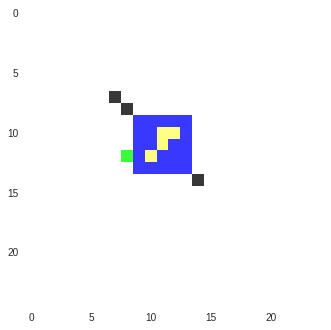

In [89]:
a = Agents(L=5)
a.run(max_iter=100,output=True,computation='parallel')
a.plot(-1,showgradient=False)

Agent 8: [(6, 9),🡕,on]-->[(5, 9),🡑,on]
Neighbors: (6, 8) (7, 8)
Edgefollows: (5, 9) (7, 9) (5, 8)


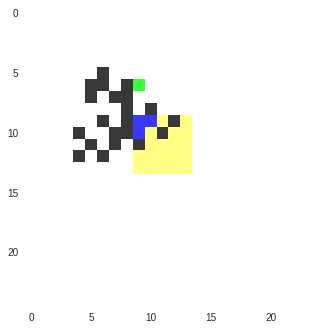

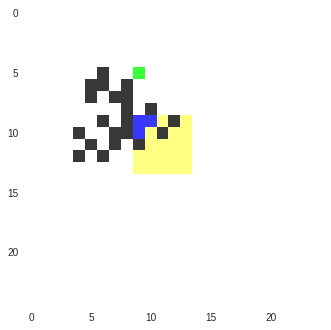

In [90]:
a.plot(100,showgradient=False)

Agent 1: [(8, 11),🡒,on]-->[(8, 12),🡒,on]
Neighbors: (7, 11) (9, 12) (9, 11) (9, 10)
Edgefollows: (8, 12) (8, 10)


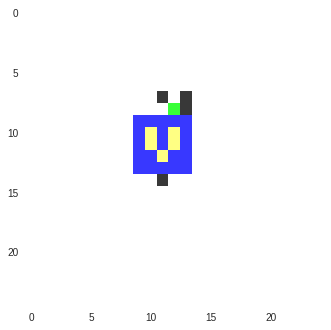

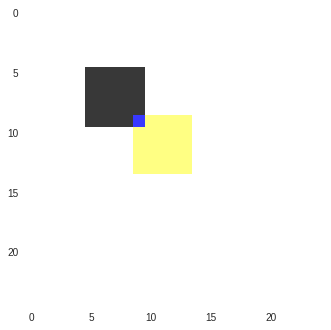

In [83]:
a.logstr

[]

In [96]:

outcome = True
count = 0
while outcome:
  a = Agents(L=5)
  outcome = a.run(max_iter=100,output=True)
  count += 1
  print count
print 'num trials before stop:',count

running...
       ...0%
       ...10%


KeyboardInterrupt: ignored

______________________________
t=1
Agent 3: [(5, 8),🡓,on]-->[(4, 8),🡑,on]
Neighbors: (5, 7) (5, 9) (6, 7) (6, 8) (6, 9)
Edgefollows: (4, 8) (4, 9) (4, 7)


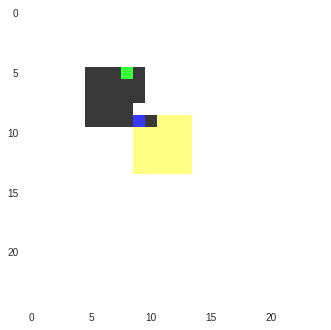

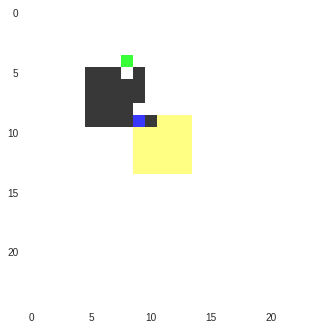

______________________________
t=101
Agent 17: [(10, 5),🡐,on]-->[(11, 4),🡗,on]
Neighbors: (9, 4) (9, 6) (10, 4) (10, 6)
Edgefollows: (9, 5) (11, 6) (11, 5) (11, 4)


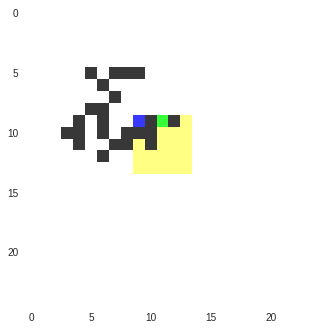

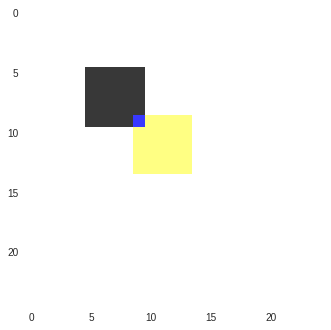

In [99]:
for t in range(1,1000,100):
  print '______________________________'
  print 't='+str(t)
  try:
    a.plot(t)
  except:
    break
a.plot(-1)